<a href="https://colab.research.google.com/github/StevenLevine-NOAA/NBM-Verif/blob/notebooks/NBM_Percentile_vs_Obs_Over_Time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Obs vs NBM Percentile Time Series**
This python notebook grabs NBM percentile, core deterministic, and obs data for selected variables and sites over a particular county warning area.
The idea here is to look at verification of a specific event (date/time) and to look at forecasts leading up to that event.  Hopefully, forecasts improve as forecast hour decreases.
If desired, there is an option to look only at longer range forecasts.

Three plotting options are available.  They are in separate cells so you can run or skip any or all.

Option one takes the mean forecast for NBM determinsitic, NBM 10th, 50th and 90th percentile for all obs in the warning area leading up to verification time (forecast hour 00).

Option two plots where the verifying ob lands for each site in NBM percentile space leading up to verification time (forecast hour 00).

Option three plots where the NBM determinsitc forecast lands for each site in NBM percentile space leading up to verification time (forecast hour 00).

 14-Sep-2023: Updated code to make more consistent with single percentile plotter, fixed bug when downloading ob from region rather than cwa

 14-March 2023: Added Capability for maximum wind (no determinsitic data available)

 30-June-2023: Fixed nan bug in loop of map plots.

 10-July-2023: Changed interpolator so s=0, ensuring interpolation line goes through relevant points.  Also fixed bug where 0-precip obs were being replaced with NaNs (they are now 0's)

 18-July-2023: Forecast lookback now goes every 12 hours rather than 24.  May add 6-hour intervals where possible in the future.

 18-Sept-2023: Fixed a few typos, separated out plotting axes for various graphics

 27-Feb-2024: Fixed bug with ob/forecast timing for minT.

 29-Feb-2024: Added ability to plot O-F for core and various percentiles over time.

*-Steve Levine NWS MDL/SMD 2-Mar-2023*

**IMPORTANT:** These first two cells must be run in the proper before anything else when starting this notebook.  However the only need to be run once.

After running cell 1, you will get a crash message.  You will need to wait a few seconds after it appears, but you can otherwise ignore it and run cell 2.

In [1]:
#@title Initialize Notebook Part 1
!pip install -q condacolab
import condacolab
condacolab.install()

⏬ Downloading https://github.com/conda-forge/miniforge/releases/download/23.11.0-0/Mambaforge-23.11.0-0-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:19
🔁 Restarting kernel...


In [1]:
#@title Initialize Notebook Part 2
!mamba install -q -c conda-forge cartopy contextily pyproj pyepsg pygrib netCDF4

import numpy as np
from scipy.interpolate import CubicSpline as cs, UnivariateSpline as us
import pandas as pd
from urllib.request import urlretrieve, urlopen
import requests
from datetime import datetime, timedelta
import json
from netCDF4 import Dataset
import pygrib
import pyproj
from pyproj import Proj, transform
import os, re, sys, traceback
#from google.colab import runtime

import matplotlib
from matplotlib.colors import LinearSegmentedColormap
#from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.axes as maxes
import matplotlib.patheffects as PathEffects
from matplotlib.path import Path
from matplotlib.textpath import TextToPath
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties
matplotlib.rcParams['font.sans-serif'] = 'Liberation Sans'
matplotlib.rcParams['font.family'] = "sans-serif"
from matplotlib.cm import get_cmap
import seaborn as sns

from cartopy import crs as ccrs, feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import contextily as cx
import itertools

import zipfile

import warnings
warnings.filterwarnings("ignore")

Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... done


**AFTER INITIALIZATION**
The cells above only need to be run once.  Now, you can change the options below and run as many times as you want.  Each run will create new output files.

**NOTE:** "NWS" In network_selection means METAR sites.
use_stageiv only applies when looking at qpf.

"qpf" means qpf24.

"snow" means snow24

In [2]:
#@title Select Forecasts to Verify and Download Ob Data {display-mode: "form"}

element = "mint" #@param ["maxt","mint","qpf","maxwind","snow"]
valid_date = "2024-02-27" #@param{type:"date"}
fcst_start = "2024-02-20" #@param{type:"date"}
fcst_end = "2024-02-26" #@param{type:"date"}
region_selection = "CWA" #@param ["WR","SR","ER","CR","AR","CONUS","CWA"]
network_selection="NWS+RAWS" #@param ["NWS", "RAWS", "NWS+RAWS", "NWS+RAWS+HADS", "ALL", "CUSTOM", "LIST"]
cwa_id="BIS,GGW,BYZ,ABR,UNK,FGF,FSD,MPX" #@param {type:"string"}
#compare_to="NBM_D" #@param ["NBM_P50", "NBM_D", "MOS"]
use_stageiv = True #@param {type:"boolean"}
use_nohrsc = True #@param {type:"boolean"}
#nbm_init_hour="12"
export_ob_csv = True #@param {type:"boolean"}
export_df_csv = True #@param {type:"boolean"}

def K_to_F(kelvin):
  fahrenheit = 1.8*(kelvin-273)+32.
  return fahrenheit

def mm_to_in(millimeters):
  inches = millimeters * 0.0393701
  return inches

def mps_to_kts(mps):
  kts = mps * 1.94384
  return kts

def meters_to_in(meters):
  inches = meters*39.3701
  return inches

fcst_start_date=datetime.strptime(fcst_start,'%Y-%m-%d')
fcst_end_date=datetime.strptime(fcst_end,'%Y-%m-%d')
fcst_valid_date=datetime.strptime(valid_date,'%Y-%m-%d')

if fcst_start_date > fcst_end_date:
  raise Exception("FATAL ERROR: INVALID DATE RANGE (start date is later than end date)")
elif fcst_valid_date <= fcst_end_date:
  raise Exception("FATAL ERROR: INVALID DATE RANGE (Valid date is before forecast end date)")
elif fcst_start_date >= fcst_valid_date:
  raise Exception("FATAL ERROR: INVALID DATE RANGE (Forecast start date is later than valid date)")

#nbm_init = datetime.strptime(nbm_init_date,'%Y-%m-%d') + timedelta(hours=int(nbm_init_hour))

if element == "maxt":
  nbm_core_valid_hour="00"
  nbm_qmd_valid_hour="06"
  valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
  valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(days=1)
  obs_start_hour = "1200"
  obs_end_hour = "0600"
  ob_stat = "maximum"
  valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
  rangeOfDays=fcst_valid_date-fcst_start_date
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for maxT!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")

elif element == "mint":
  nbm_core_valid_hour="12"
  nbm_qmd_valid_hour="18"
  valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
  valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d')
  obs_start_hour = "0000"
  obs_end_hour = "1800"
  ob_stat = "minimum"
  valid_end_datetime = valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
  rangeOfDays=valid_date_start-valid_date_start
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for minT!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")

elif element == "qpf" or element == "snow":
  nbm_core_valid_hour = "12" #str(qpf_valid_time)
  nbm_valid_hour = "12" #str(qpf_valid_time)
  nbm_qmd_valid_hour="12" #str(qpf_valid_time)
  valid_date = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=12) #timedelta(hours=int(qpf_valid_time))
  valid_date_start = valid_date - timedelta(hours=24)
  valid_date_end = valid_date
  obs_start_hour = "1200" #str(qpf_valid_time)+"00"
  obs_end_hour = "1200" #str(qpf_valid_time)+"00"
  ob_stat = "total"
  valid_end_datetime = valid_date_end
  rangeOfDays=valid_date_end-valid_date_start
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for QPF24!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")
#elif element == "snow":
#  nbm_core_valid_hour = "12"
#  nbm_valid_hour = "12"
#  nbm_qmd_valid_hour = "12"
#  valid_date = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(hours=12) #timedelta(hours=int(qpf_valid_time))
#  valid_date_start = valid_date - timedelta(hours=24)
#  valid_date_end = valid_date
#  obs_start_hour = "1200" #str(qpf_valid_time)+"00"
#  obs_end_hour = "1200" #str(qpf_valid_time)+"00"
#  ob_stat = "total"
#  valid_end_datetime = valid_date_end
#  rangeOfDays=valid_date_end-valid_date_start
elif element == "maxwind":
  nbm_qmd_valid_hour="06"
  obs_start_hour="0600"
  obs_end_hour="0600"
  ob_stat="maximum"
  valid_date_start = datetime.strptime(valid_date,'%Y-%m-%d')
  valid_date_end = datetime.strptime(valid_date,'%Y-%m-%d') + timedelta(days=1)
  valid_end_datetime=valid_date_end + timedelta(hours=(int(obs_end_hour)/100))
  rangeOfDays=valid_date_end-valid_date_start
  #nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
  if rangeOfDays.days > 9:
    print("     ❌ FATAL ERROR: Can only look back up to 9 days for Maxwind!")
    raise Exception("Based on your entries for fcst_start and valid_date, you are looking back " + str(rangeOfDays.days) + " days.  Aborting...")

#set default website strings
synoptic_token = "62e9269f0a164da1b2415ddcf8f4f29e"
statistics_api = "https://api.synopticlabs.org/v2/stations/statistics?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"

# Setup a dictionary for translating a form selection into a something we can pass to mesowest API
network_dict = {"NWS+RAWS+HADS":"&network=1,2,106","NWS+RAWS":"&network=1,2", "NWS":"&network=1", "RAWS": "&network=2", "ALL":""} #, "CUSTOM": "&network="+network_input, "LIST": "&stid="+network_input}
network_string = network_dict[network_selection]

def cwa_list(input_region):
  region_dict={"WR":"BYZ,BOI,LKN,EKA,FGZ,GGW,TFX,VEF,LOX,MFR,MTR,MSO,PDT,PSR,PIH,PQR,REV,STO,SLC,SGX,HNX,SEW,OTX,TWC",
              "CR":"ABR,BIS,CYS,LOT,DVN,BOU,DMX,DTX,DDC,DLH,FGF,GLD,GJT,GRR,GRB,GID,IND,JKL,EAX,ARX,ILX,LMK,MQT,MKX,MPX,LBF,APX,IWX,OAX,PAH,PUB,UNR,RIW,FSD,SGF,LSX,TOP,ICT",
              "ER":"ALY,LWX,BGM,BOX,BUF,BTV,CAR,CTP,RLX,CHS,ILN,CLE,CAE,GSP,MHX,OKX,PHI,PBZ,GYX,RAH,RNK,AKQ,ILM",
              "SR":"ABQ,AMA,FFC,EWX,BMX,BRO,CRP,EPZ,FWD,HGX,HUN,JAN,JAX,KEY,MRX,LCH,LZK,LUB,MLB,MEG,MFL,MOB,MAF,OHX,LIX,OUN,SJT,SHV,TAE,TBW,TSA",
              "AR":"AJK,ARH,AFC"}
  if(input_region in ["WR","CR","SR","ER","AR"]):
    cwas_list=region_dict[input_region]
  else:
    cwas_list=input_region
  return cwas_list

if region_selection == "CONUS":
  region_list = ["WR", "CR", "SR", "ER"]
elif region_selection == "CWA":
  region_list = [cwa_id]
else:
  region_list = [region_selection]

def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)

def project_hrap(lon, lat, s4x, s4y):
  lon = float(lon)
  lat = float(lat)

  globe = ccrs.Globe(semimajor_axis=6371200)
  hrap_ccrs = proj = ccrs.Stereographic(central_latitude=90.0,
                          central_longitude=255.0,
                          true_scale_latitude=60.0, globe=globe)
  latlon_ccrs = ccrs.PlateCarree()
  hrap_coords = hrap_ccrs.transform_point(lon,lat,src_crs=latlon_ccrs)
  hrap_idx = ll_to_index(s4x, s4y, hrap_coords[0], hrap_coords[1])
  return hrap_idx

def nohrsc_ll2ij(lon,lat,gridlons,gridlats):
  #for a lat/lon grid
  lon = float(lon)
  lat = float(lat)
  lonidx=(np.abs(lon-gridlons)).argmin()
  latidx=(np.abs(lat-gridlats)).argmin()
  return(latidx,lonidx)

def get_stageiv():
  siv_url = "https://water.weather.gov/precip/downloads/"+valid_date_end.strftime('%Y')+"/"+valid_date_end.strftime('%m')+"/"+valid_date_end.strftime('%d')+"/nws_precip_1day_"+valid_date_end.strftime('%Y%m%d')+"_conus.nc"
  data = urlopen(siv_url).read()

  nc = Dataset('data', memory=data)
  #with Dataset(siv_file, 'r') as nc:
  stageIV = nc.variables['observation']
  s4x = nc.variables['x']
  s4y = nc.variables['y']
  return stageIV, s4x, s4y

def get_nohrsc():
  nohrsc_url = "https://www.nohrsc.noaa.gov/snowfall_v2/data/"+valid_date_end.strftime('%Y%m')+"/sfav2_CONUS_24h_"+valid_date_end.strftime('%Y%m%d%H')+".nc"
  data = urlopen(nohrsc_url).read()

  nc = Dataset('data',memory=data)
  snow=np.asarray(nc.variables['Data']) #make lon by lat array (original lat by lon)
  snowlat = np.asarray(nc.variables['lat'])
  snowlon = np.asarray(nc.variables['lon'])
  return snow,snowlon,snowlat


#downlaod/process obs
print('Getting obs...')
obs={}
if os.path.exists("obs"):
  pass
else:
  os.mkdir("obs")
for region in region_list:
  json_name="obs/Obs_"+element+"_"+valid_date_start.strftime('%Y%m%d')+obs_start_hour+"_"+valid_date_end.strftime('%Y%m%d')+obs_end_hour+"_"+region+".json"
  if os.path.exists(json_name):
    print("Skipping download since JSON obs file already exists")
    pass
  else:
    if element == "mint" or element == "maxt":
      api_token = "&token="+synoptic_token
      station_query = "&cwa="+cwa_list(region)
      vars_query = "&vars=air_temp"
      start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
      end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
      stat_type = "&type="+ob_stat
      network_query = network_string
      api_extras = "&units=temp%7Cf&within=1440&status=active"
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query + api_extras
    elif element == "maxwind":
      api_token = "&token="+synoptic_token
      station_query = "&cwa="+cwa_list(region)
      vars_query = "&vars=wind_speed"
      start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
      end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
      stat_type = "&type="+ob_stat
      network_query = network_string
      obs_url = statistics_api + api_token + station_query + vars_query + start_query + end_query + stat_type + network_query
    elif element == "qpf":
      if use_stageiv:
        print("Downloading stage IV data...")
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        stageIV, s4xs, s4ys = get_stageiv()
        print("Meshing stage IV data...")
        s4xs, s4ys = np.meshgrid(s4xs, s4ys)
      else:
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
    elif element == "snow":
      if use_nohrsc:
        print("Using NOHRSC data")
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation"
        network_query = network_string
        obs_url = metadata_api + api_token + station_query + network_query + api_extras
        snow,snowlon,snowlat = get_nohrsc()
        snowlons,snowlats = np.meshgrid(snowlon,snowlat)
      else:
        api_token = "&token="+synoptic_token
        station_query = "&cwa="+cwa_list(region)
        api_extras = "&fields=status,latitude,longitude,name,elevation&obtimezone=utc"
        network_query = network_string
        vars_query = "&pmode=totals"
        units_query = "&units=precip|in"
        start_query = "&start="+valid_date_start.strftime('%Y%m%d')+obs_start_hour
        end_query = "&end="+valid_date_end.strftime('%Y%m%d')+obs_end_hour
        obs_url = precipitation_api + api_token + station_query + network_query + vars_query + start_query + end_query + units_query + api_extras
    print("Obs url: " + obs_url)
    urlretrieve(obs_url,json_name)

if os.path.exists(json_name):
  with open(json_name) as json_file:
    obs_json = json.load(json_file)
    print ("Loaded Obs JSON file line 219: " + json_name)
    obs_lats = []
    obs_lons = []
    obs_value = []
    obs_elev = []
    obs_stid = []
    obs_name = []
    for stn in obs_json["STATION"]:
      if stn["STID"] is None:
        stid = "N0N3"
      else:
        stid = stn["STID"]
        name = stn["NAME"]
        if stn["ELEVATION"] and stn["ELEVATION"] is not None:
          elev = stn["ELEVATION"]
        else:
          elev = -999
        lat = stn["LATITUDE"]
        lon = stn["LONGITUDE"]
        if element == "mint" or element == "maxt":
          if 'air_temp_set_1' in stn['STATISTICS'] and stn['STATISTICS']['air_temp_set_1']:
            if ob_stat in stn['STATISTICS']['air_temp_set_1'] and float(stn["LATITUDE"]) != 0.:
              stat = stn['STATISTICS']['air_temp_set_1'][ob_stat]
              obs_stid.append(str(stid))
              obs_name.append(str(name))
              obs_elev.append(float(elev))
              obs_lats.append(float(lat))
              obs_lons.append(float(lon))
              obs_value.append(float(stat))
        elif element == "maxwind":
          if 'wind_speed_set_1' in stn['STATISTICS'] and stn['STATISTICS']['wind_speed_set_1']:
            if ob_stat in stn['STATISTICS']['wind_speed_set_1'] and float(stn["LATITUDE"]) != 0.:
              stat = stn['STATISTICS']['wind_speed_set_1'][ob_stat]
              obs_stid.append(str(stid))
              obs_name.append(str(name))
              obs_elev.append(float(elev))
              obs_lats.append(float(lat))
              obs_lons.append(float(lon))
              obs_value.append(mps_to_kts(float(stat)))
        elif element == "qpf" or element == "snow":
          if (stn["STATUS"] == "ACTIVE") and float(stn["LATITUDE"]) < 50.924 and float(stn["LONGITUDE"]) > -125.650 and float(stn["LONGITUDE"]) < -66.008:
            obs_stid.append(str(stid))
            obs_name.append(str(name))
            obs_elev.append(float(elev))
            obs_lats.append(float(lat))
            obs_lons.append(float(lon))
            if element == "qpf" and use_stageiv is True:
              coords = project_hrap(lon,lat,s4xs,s4ys)
              siv_value = float(stageIV[coords])
              if (siv_value >= 0.01):
                obs_value.append(siv_value)
              else:
                obs_value.append(0.0)
            elif  element == "qpf" and use_stageiv is False:
              if "precipitation" in stn["OBSERVATIONS"]:
                if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                  ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                  if ptotal >= 0.005:
                    obs_value.append(ptotal)
                  else:
                    obs_value.append(0.0)
                else:
                  obs_value.append(np.nan)
              else:
                obs_value.append(np.nan)
            elif use_nohrsc and element == "snow":
              coords = nohrsc_ll2ij(lon,lat,snowlon,snowlat)
              nohrsc_value = meters_to_in(float(snow[coords]))
              if nohrsc_value >= 0.005:
                obs_value.append(nohrsc_value)
              elif nohrsc_value < 0.0:
                obs_value.append(np.nan)
              else:
                obs_value.append(0.0)
            else:
              if "precipitation" in stn["OBSERVATIONS"]:
                if "total" in stn["OBSERVATIONS"]["precipitation"][0]:
                  ptotal = stn["OBSERVATIONS"]["precipitation"][0]["total"]
                  if ptotal >= 0.01:
                    obs_value.append(ptotal)
                  else:
                    obs_value.append(np.nan)
                else:
                    obs_value.append(np.nan)
              else:
                obs_value.append(np.nan)
    print("Finished loading JSON obs into dictionary!")
    csv_name="obs_"+element+"_"+region+"_"+fcst_valid_date.strftime("%Y%m%d")+".csv"
    obs[region] = pd.DataFrame()
    obs[region]["stid"] = obs_stid
    obs[region]["name"] = obs_name
    obs[region]["elevation"] = obs_elev
    obs[region]["lat"] = obs_lats
    obs[region]["lon"] = obs_lons
    #if element == "maxwind":
    #  obs[cwa]["ob_"+element] = mps_to_kts(obs_value)
    #else:
  obs[region]["ob_"+element] = obs_value
  if export_ob_csv is True:
    obs[region].to_csv(csv_name)
    print("Written Obs CSV file: " + csv_name)

if cwa_id in ["SJU","HFO"] and element in ["maxt","mint","maxwind","snow"]:
  print("WARNING: Percentiles for " + element + " do not exist for PR or HI")
  print("Obs are downloading without issue, but forecast data will not download!")

Getting obs...
Obs url: https://api.synopticlabs.org/v2/stations/statistics?&token=62e9269f0a164da1b2415ddcf8f4f29e&cwa=BIS,GGW,BYZ,ABR,UNK,FGF,FSD,MPX&vars=air_temp&start=202402270000&end=202402271800&type=minimum&network=1,2&units=temp%7Cf&within=1440&status=active
Loaded Obs JSON file line 219: obs/Obs_mint_202402270000_202402271800_BIS,GGW,BYZ,ABR,UNK,FGF,FSD,MPX.json
Finished loading JSON obs into dictionary!
Written Obs CSV file: obs_mint_BIS,GGW,BYZ,ABR,UNK,FGF,FSD,MPX_20240227.csv


Now, we download the relevant NBM data.  Files come from the AWS 'big data' NOAA server.

Note that this section will have to be re-run whenever the above cell is re-run.

In [16]:
#@title Download Forecast Data and Match with Obs

def ll_to_index(datalons, datalats, loclon, loclat):
  abslat = np.abs(datalats-loclat)
  abslon = np.abs(datalons-loclon)
  c = np.maximum(abslon, abslat)
  latlon_idx_flat = np.argmin(c)
  latlon_idx = np.unravel_index(latlon_idx_flat, datalons.shape)
  return(latlon_idx)

def find_roots(x,y):
  s = np.abs(np.diff(np.sign(y))).astype(bool)
  return x[:-1][s] + np.diff(x)[s]/(np.abs(y[1:][s]/y[:-1][s])+1)

def download_subset(remote_url, remote_file, local_filename):
  print("   > Downloading a subset of NBM gribs")
  if os.path.exists("nbm"):
    pass
  else:
    os.mkdir("nbm")
  local_file = "nbm/"+local_filename
  if "qmd" in remote_file:
    if element == "maxt":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day max fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "mint":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':TMP:2 m above ground:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day min fcst:'
      else:
        search_string = f':TMP:2 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour min fcst:'
    elif element == "maxwind":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 == 0):
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start/24))}-{str(int(nbm_qmd_forecasthour/24))} hour max fcst:'
      else:
        search_string = f':WIND:10 m above ground:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour max fcst:'
    elif element == "qpf":
      if (int(nbm_qmd_forecasthour_start) % 24 == 0) and (int(nbm_qmd_forecasthour) % 24 ==0):
        search_string = f':APCP:surface:{str(int(int(nbm_qmd_forecasthour_start)/24))}-{str(int(int(nbm_qmd_forecasthour)/24))} day acc fcst:'
      else:
        search_string = f':APCP:surface:{str(int(nbm_qmd_forecasthour_start))}-{str(int(nbm_qmd_forecasthour))} hour acc fcst:'
  elif "core" in remote_file:
    if element == "maxt":
      search_string = f':TMAX:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour max fcst:'
    elif element == "mint":
      search_string = f':TMIN:2 m above ground:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour min fcst:'
    elif element == "snow":
      search_string = f':ASNOW:surface:{str(int(nbm_core_forecasthour_start))}-{str(int(nbm_core_forecasthour))} hour acc'
  #print(search_string)
  idx = remote_url+".idx"
  r = requests.get(idx)
  if not r.ok:
    print('     ❌ SORRY! Status Code:', r.status_code, r.reason)
    print(f'      ❌ It does not look like the index file exists: {idx}')

  lines = r.text.split('\n')
  expr = re.compile(search_string)
  byte_ranges = {}
  for n, line in enumerate(lines, start=1):
      # n is the line number (starting from 1) so that when we call for
      # `lines[n]` it will give us the next line. (Clear as mud??)

      # Use the compiled regular expression to search the line
      if expr.search(line):
          # aka, if the line contains the string we are looking for...

          # Get the beginning byte in the line we found
          parts = line.split(':')
          rangestart = int(parts[1])

          # Get the beginning byte in the next line...
          if n+1 < len(lines):
              # ...if there is a next line
              parts = lines[n].split(':')
              rangeend = int(parts[1])
          else:
              # ...if there isn't a next line, then go to the end of the file.
              rangeend = ''

          # Store the byte-range string in our dictionary,
          # and keep the line information too so we can refer back to it.
          byte_ranges[f'{rangestart}-{rangeend}'] = line
          #print(line)
  for i, (byteRange, line) in enumerate(byte_ranges.items()):

        if i == 0:
            # If we are working on the first item, overwrite the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} > {local_file}'
        else:
            # If we are working on not the first item, append the existing file.
            curl = f'curl -s --range {byteRange} {remote_url} >> {local_file}'
        try:
          num, byte, date, var, level, forecast, _ = line.split(':')
        except:
          pass

        #print(f'  Downloading GRIB line [{num:>3}]: variable={var}, level={level}, forecast={forecast}')
        os.system(curl)

  if os.path.exists(local_file):
      print(f'      ✅ Success! Searched for [{search_string}] and got [{len(byte_ranges)}] GRIB fields and saved as {local_file}')
      return local_file
  else:
      print(print(f'      ❌ Unsuccessful! Searched for [{search_string}] and did not find anything!'))


def daterange(element,start_date,end_date):
  end_date=end_date+timedelta(hours=12) #ending at 12Z
  if element == "snow":
    return pd.date_range(start=start_date,end=end_date,freq='12H',inclusive='left')
  else:
    return pd.date_range(start=start_date,end=end_date,freq='12H',inclusive='both')

if "AR" in region_list or "AJK" in region_list or "ARH" in region_list or "AFC" in region_list:
  rg="ak"
elif "HFO" in region_list:
  rg="hi"
elif "SJU" in region_list:
  rg="pr"
else:
  rg="co"

fcst={} #fcst is dictionary of dataframes by cwa, much like obs
masterfcst=pd.DataFrame() #to concatenate to

fcst_stop_date=fcst_end_date

for nbmdate in daterange(element,fcst_start_date,fcst_stop_date):
    nbmdatestr=nbmdate.strftime("%Y-%m-%d-%H")
    nbm_init_hour=nbmdate.strftime('%H')
    print("Grabbing file from: " + nbmdatestr)
    if element == "snow":
      nbm_init=nbmdate + timedelta(hours=1) #3)
    else:
      nbm_init=nbmdate #+ timedelta(hours=12)
    #print("Pulling determinisitc data for: " + nbm_init)
    if element == "maxt":
      nbm_core_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_core_valid_hour)+24)
      nbm_qmd_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_qmd_valid_hour)+24)
      core_init = nbm_init + timedelta(hours = 7)
      nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init
      nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
      nbm_core_forecasthour_start = nbm_core_forecasthour - 12
    elif element == "mint":
      nbm_core_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_core_valid_hour))
      nbm_qmd_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_qmd_valid_hour))
      core_init = nbm_init + timedelta(hours = 7)
      nbm_core_fhdelta = nbm_core_valid_end_datetime - core_init
      nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
      nbm_core_forecasthour_start = nbm_core_forecasthour - 12
    elif element == "qpf" or element == "snow":
      core_init = nbm_init
      nbm_core_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_core_valid_hour))
      nbm_qmd_valid_end_datetime = fcst_valid_date + timedelta(hours=int(nbm_qmd_valid_hour))
      nbm_core_fhdelta = nbm_core_valid_end_datetime - nbm_init
      nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
      nbm_core_forecasthour_start = nbm_core_forecasthour - 24
    elif element == "maxwind":
      #adding core valid times here to help out with plotting later
      #They are dummy values as there is no determinsitic data for max wind
      nbm_qmd_valid_end_datetime = valid_date_end + timedelta(hours=int(nbm_qmd_valid_hour))
      nbm_core_valid_end_datetime = nbm_qmd_valid_end_datetime - timedelta(hours=12)
      nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
      nbm_core_fhdelta = nbm_core_valid_end_datetime - nbm_init
      nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
      nbm_core_forecasthour = nbm_core_fhdelta.total_seconds() / 3600.
    nbm_qmd_fhdelta = nbm_qmd_valid_end_datetime - nbm_init
    nbm_qmd_forecasthour = nbm_qmd_fhdelta.total_seconds() / 3600.
    if element == "qpf" or element == "maxwind" or element == "snow":
      nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 24
    else:
      nbm_qmd_forecasthour_start = nbm_qmd_forecasthour - 18
    #get file names
    nbm_init_filen = nbm_init.strftime('%Y%m%d') + "_" + nbm_init.strftime('%H')
    nbm_url_base = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+nbm_init.strftime('%Y%m%d') \
                +"/"+nbm_init.strftime('%H')+"/"
    if element != "maxwind":
      print("Pulling determinstic data for hour: " + str(nbm_core_forecasthour))
      nbm_init_filen_core = core_init.strftime('%Y%m%d') + "_" + core_init.strftime('%H')
      nbm_url_base_core = "https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend."+core_init.strftime('%Y%m%d') \
                  +"/"+core_init.strftime('%H')+"/"
      temp_vars = ["maxt","mint"]
      if (element == "qpf"):
        detr_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{rg}.grib2'
        detr_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{rg}.{element}_subset.grib2'
        if (int(nbm_qmd_forecasthour) < 12):
          break
        detr_url = nbm_url_base+"qmd/"+detr_file

      else: #temperature or snow
      #elif any(te in element for te in temp_vars):
        detr_file = f"blend.t{int(core_init.strftime('%H')):02}z.core.f{int(nbm_core_forecasthour):03}.{rg}.grib2"
        detr_file_subset = f"blend.t{int(core_init.strftime('%H')):02}z.core.{nbm_init_filen_core}f{int(nbm_core_forecasthour):03}.{rg}.{element}_subset.grib2"
        if (int(nbm_core_forecasthour) < 12):
          break
        detr_url = nbm_url_base_core+"core/"+detr_file

      #download file if we don't have it yet
      if os.path.exists("nbm/"+detr_file_subset):
        print("   > NBM deterministic already exists")
      else:
        print("   > Getting NBM deterministic")
        if os.path.exists("nbm"):
          pass
        else:
          os.mkdir("nbm")
      #urlretrieve(detr_url, "nbm/"+detr_file)
      download_subset(detr_url, detr_file, detr_file_subset)
      #extract deterministic values
      nbmd = pygrib.open("nbm/"+detr_file_subset)
      if element == "maxt":
        deterministic = nbmd.select(name="Maximum temperature",lengthOfTimeRange=12, stepTypeInternal="max")[0]
        deterministic_array = K_to_F(deterministic.values)
      elif element == "mint":
        deterministic = nbmd.select(name="Minimum temperature",lengthOfTimeRange=12, stepTypeInternal="min")[0]
        deterministic_array = K_to_F(deterministic.values)
      elif element == "qpf":
        deterministic = nbmd.select(name="Total Precipitation",lengthOfTimeRange=24)[-1]
        deterministic_array = mm_to_in(deterministic.values)
      elif element == "snow":
        #deterministic = nbmd.select(name="Total snowfall",lengthOfTimeRange=24)[7] #look at 8th record
        deterministic = nbmd.select(name="unknown",lengthOfTimeRange=24)[7]
        deterministic_array = mm_to_in(deterministic.values)
      nbmlats, nbmlons = deterministic.latlons()
      nbmd.close()

      for region in region_list:
        fcst[region] = pd.DataFrame()
        point_lats = obs[region]["lat"].values
        point_lons = obs[region]["lon"].values
        stations = obs[region]["stid"].values
        obvals = obs[region]["ob_"+element].values
        fcsthrs=np.full(len(stations),nbm_core_forecasthour)
        detr_values = []
        nbm_fidx = []
      #if element == "maxwind":
        #detr_values=np.empty(np.shape(stations))
        #detr_values.fill(np.nan)
        #for i in range(0,len(point_lats)):
        #  coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
        #  nbm_fidx.append(coords)
      #else:
        for i in range(0, len(point_lats)):
          coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
          nbm_fidx.append(coords)
          detr_value = deterministic_array[coords]
          detr_values.append(detr_value)
        fcst[region]["stid"] = stations
        fcst[region]["NBM_fidx"] = nbm_fidx
        fcst[region]["NBM_D"] = detr_values
        fcst[region]["forecast_hour"] = fcsthrs
        fcst[region]["OB"] = obvals
    else: #for maxwind (no deterministic available)
      print("MAXWIND: Putting stations locations into dataframe")
      for region in region_list:
        fcst[region] = pd.DataFrame()
        point_lats = obs[region]["lat"].values
        point_lons = obs[region]["lon"].values
        stations = obs[region]["stid"]
        obvals = obs[region]["ob_"+element].values
        nbm_fidx = []
        nbmlats = None
        nbmlons = None
        fcsthrs=np.full(len(stations),nbm_core_forecasthour)
        detr_values=np.empty(np.shape(stations))
        detr_values.fill(np.nan)
        fcst[region]["stid"] = stations
        fcst[region]["NBM_D"] = detr_values
        fcst[region]["forecast_hour"] = fcsthrs
        fcst[region]["OB"] = obvals

    if element == "snow":
      perc_list = [5,10,25,50,75,90,95]
    else:
      perc_list = [1,5,10,20,30,40,50,60,70,80,90,95,99]
    perc_dict = {"maxt":"maxt18p", "mint":"mint18p", "qpf":"qpf24p","snow":"snow24p"}
    if element == "snow":
      perc_file=f"blend.t{int(core_init.strftime('%H')):02}z.core.f{int(nbm_core_forecasthour):03}.{rg}.grib2"
      perc_url=nbm_url_base_core+"core/"+perc_file
    else:
      perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{rg}.grib2'
      perc_url = nbm_url_base+"qmd/"+perc_file
    #perc_file = f'blend.t{int(nbm_init_hour):02}z.qmd.f{int(nbm_qmd_forecasthour):03}.{rg}.grib2'
    perc_file_subset = f'blend.t{int(nbm_init_hour):02}z.qmd.{nbm_init_filen}{nbm_init_filen}f{int(nbm_qmd_forecasthour):03}.{rg}.{element}_subset.grib2'
    #perc_url = nbm_url_base+"qmd/"+perc_file
    print("  >> perc_url = " + perc_url)
    print("  >> perc_file_subset = " + perc_file_subset)
    if rg in ["pr","hi"] and element in ["maxt","mint","maxwind","snow"]:
      raise Exception ("FATAL ERROR: Percentiles for " + element + " do not exist for PR or HI")
    if os.path.exists("nbm/"+perc_file_subset):
      print("   > NBM probabilistic already exists")
    else:
      #urlretrieve(perc_url, "nbm/"+perc_file)
      print("   > Getting NBM probabilistic")
      download_subset(perc_url, perc_file, perc_file_subset)

    nbmperc = pygrib.open("nbm/"+perc_file_subset)
    print('   > Extracting NBM Probabilistic')
    #load percentile data
    for perc in perc_list:
      print(f'     >> Extracting NBM P{int(perc):01}')
      perc_name = "NBM_P"+str(perc)
      if element == "maxt":
        percdata = K_to_F(nbmperc.select(name="Maximum temperature at 2 metres since previous post-processing", stepTypeInternal="max", percentileValue=perc)[0].values)
      elif element == "mint":
        percdata = K_to_F(nbmperc.select(name="Minimum temperature at 2 metres since previous post-processing", stepTypeInternal="min", percentileValue=perc)[0].values)
      elif element == "qpf":
        percdata = mm_to_in(nbmperc.select(name="Total Precipitation",lengthOfTimeRange=24, percentileValue=perc)[0].values)
      elif element == "maxwind":
        percinv = nbmperc.select(name="10 metre wind speed",lengthOfTimeRange=24,stepTypeInternal="max",percentileValue=perc)[0]
        percdata=mps_to_kts(percinv.values) #knots
      elif element == "snow":
        #percinv = nbmperc.select(name="Total snowfall",lengthOfTimeRange=24,percentileValue=perc)[0]
        percinv = nbmperc.select(name="unknown",lengthOfTimeRange=24,percentileValue=perc)[0]
        percdata=meters_to_in(percinv.values)
      #get and load ob i/j points for maxwind obs (if not already defined from core/deterministic or previous file)
      if nbmlats is None:
        nbmlats,nbmlons=percinv.latlons()
        for i in range(0,len(point_lats)):
          coords = ll_to_index(nbmlons,nbmlats,point_lons[i],point_lats[i])
          nbm_fidx.append(coords)
        fcst[region]["NBM_fidx"] = nbm_fidx

      #now run the percentile calculations
      for region in region_list:
        nbm_coords = fcst[region]["NBM_fidx"].values
        perc_values = []
        for i in range(0, len(nbm_coords)):
          perc_value = percdata[nbm_coords[i]]
          perc_values.append(perc_value)
        fcst[region][perc_name] = perc_values
    nbmperc.close()
    print('Creating point distribution curves and interpolating...')
    for region in region_list:
      if element == "snow":
        perc_start = fcst[region].columns.get_loc("NBM_P5")
        perc_end = fcst[region].columns.get_loc("NBM_P95")
      else:
        perc_start = fcst[region].columns.get_loc("NBM_P1")
        perc_end = fcst[region].columns.get_loc("NBM_P99")
      all_percs = fcst[region].iloc[:, perc_start:perc_end+1].values
      var_string = "ob_"+element
      all_obs = obs[region][[var_string]].values
      all_nbmd = fcst[region][['NBM_D']].values
      all_lats = obs[region][['lat']].values
      all_lons = obs[region][['lon']].values
      obs_percs = []
      nbmd_percs = []
      mos_percs = []
      for i in range(0,len(all_obs)):
        udf = us(perc_list, all_percs[i,:], bbox=[0,100], ext=0, s=0)
        if np.isnan(all_obs[i]):
          ob_perc = np.nan
        elif all_obs[i] <= udf(0):
          ob_perc = -10
        elif all_obs[i] >= udf(100):
          ob_perc = 110
        else:
          ob_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_obs[i])
          ob_perc = ob_perc[0].round(1)

        if np.isnan(all_nbmd[i]):
          nbm_perc = np.nan
        elif all_nbmd[i] <= udf(0):
          nbm_perc = -10
        elif all_nbmd[i] >= udf(100):
          nbm_perc = 110
        else:
          nbm_perc = find_roots(np.arange(0,101,1), udf(np.arange(0,101,1)) - all_nbmd[i])
          nbm_perc = nbm_perc[0].round(1)

        if np.isnan(ob_perc):
          obs_percs.append(ob_perc)
        else:
          obs_percs.append(int(ob_perc))
        if np.isnan(nbm_perc):
          nbmd_percs.append(nbm_perc)
        else:
          nbmd_percs.append(int(nbm_perc))
      fcsthrs=np.full(len(nbmd_percs),nbm_core_forecasthour)
      fcst[region]["ob_perc"] = obs_percs
      fcst[region]["NBMd_perc"] = nbmd_percs
      fcst[region]["forecast_hour"] = fcsthrs
      fcst[region]['lat'] = all_lats
      fcst[region]['lon'] = all_lons
      tmpframe=pd.concat([masterfcst,fcst[region]])
      masterfcst=tmpframe
masterfcst.replace(-9999.0,np.nan,inplace=True)

if export_df_csv:
  csv_name="obs_"+element+"_series_valid_"+valid_end_datetime.strftime('%Y%m%d')+"_"+region+".csv"
  masterfcst.to_csv(csv_name,na_rep="MISSING")
  print("  >  Created and saved:" + csv_name)

Grabbing file from: 2024-02-20-00
Pulling determinstic data for hour: 173.0
   > NBM deterministic already exists
   > Downloading a subset of NBM gribs
      ✅ Success! Searched for [:TMIN:2 m above ground:161-173 hour min fcst:] and got [2] GRIB fields and saved as nbm/blend.t07z.core.20240220_07f173.co.mint_subset.grib2
  >> perc_url = https://noaa-nbm-grib2-pds.s3.amazonaws.com/blend.20240220/00/qmd/blend.t00z.qmd.f186.co.grib2
  >> perc_file_subset = blend.t00z.qmd.20240220_0020240220_00f186.co.mint_subset.grib2
   > NBM probabilistic already exists
   > Extracting NBM Probabilistic
     >> Extracting NBM P1
     >> Extracting NBM P5
     >> Extracting NBM P10
     >> Extracting NBM P20
     >> Extracting NBM P30
     >> Extracting NBM P40
     >> Extracting NBM P50
     >> Extracting NBM P60
     >> Extracting NBM P70
     >> Extracting NBM P80
     >> Extracting NBM P90
     >> Extracting NBM P95
     >> Extracting NBM P99
Creating point distribution curves and interpolating...


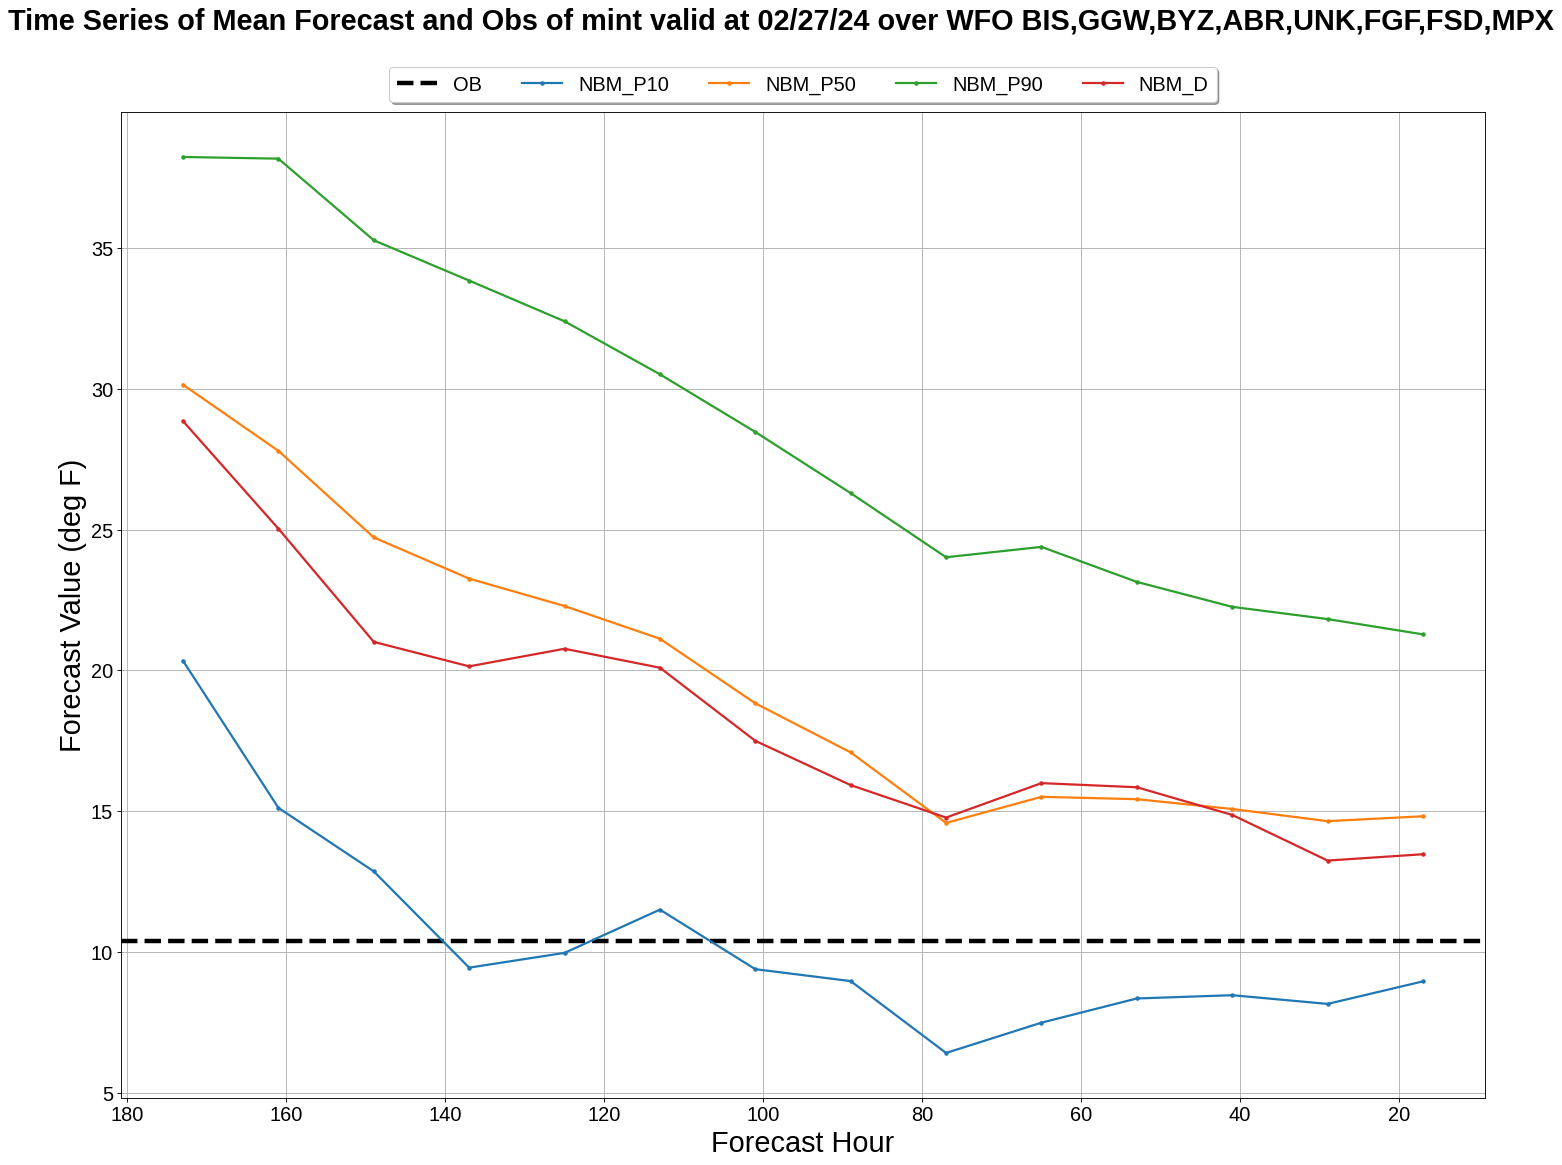

In [18]:
#@title Plotting Option One - Averaged Forecasts Over Domain
#masterfcst=masterfcst.replace(-9999.0,np.NaN,inplace=True)
matplotlib.rc('axes',facecolor='white',edgecolor='black')
units={"maxt":"deg F", "mint":"deg F", "qpf":"in", "maxwind":"kts", "snow":"in"}
figavg=plt.figure(constrained_layout=False,figsize=(22,16),dpi=80)
grid=figavg.add_gridspec(1,1)
axavg=figavg.add_subplot(1,1,1)
mosframe=masterfcst.groupby(['forecast_hour'])[['forecast_hour','OB','NBM_D','NBM_P10','NBM_P50','NBM_P90']].mean()
plt.axhline(mosframe.loc[mosframe.index[0],'OB'],color='black',linewidth=4,linestyle='dashed',label="OB")
for var in ['NBM_P10','NBM_P50','NBM_P90']:
  mosframe.plot(ax=axavg,kind="line",x="forecast_hour",y=var,grid=True,marker='o',markersize=3,fontsize=18,linewidth=2)
if element != "maxwind":
  mosframe.plot(ax=axavg,kind="line",x="forecast_hour",y='NBM_D',grid=True,marker='o',markersize=3,fontsize=18,linewidth=2)
axavg.legend(loc='lower center',bbox_to_anchor=[0.5,1.00],fancybox=True,shadow=True,ncol=6,prop={'size': 18})
axavg.set_xlim(axavg.get_xlim()[::-1])
plt.xlabel("Forecast Hour",fontsize=26)
plt.ylabel("Forecast Value (" + units[element] + ")",fontsize=26)
title_string="Time Series of Mean Forecast and Obs of " + element + " valid at " + valid_date_start.strftime('%m/%d/%y')  + " over WFO " + region
figavg.text(0.5,0.94,title_string,horizontalalignment='center',verticalalignment='bottom',weight='bold',fontsize=26)
figavg.savefig(region+"_"+element+"_mean_valid_" + valid_date_start.strftime('%m%d%y')+".png")

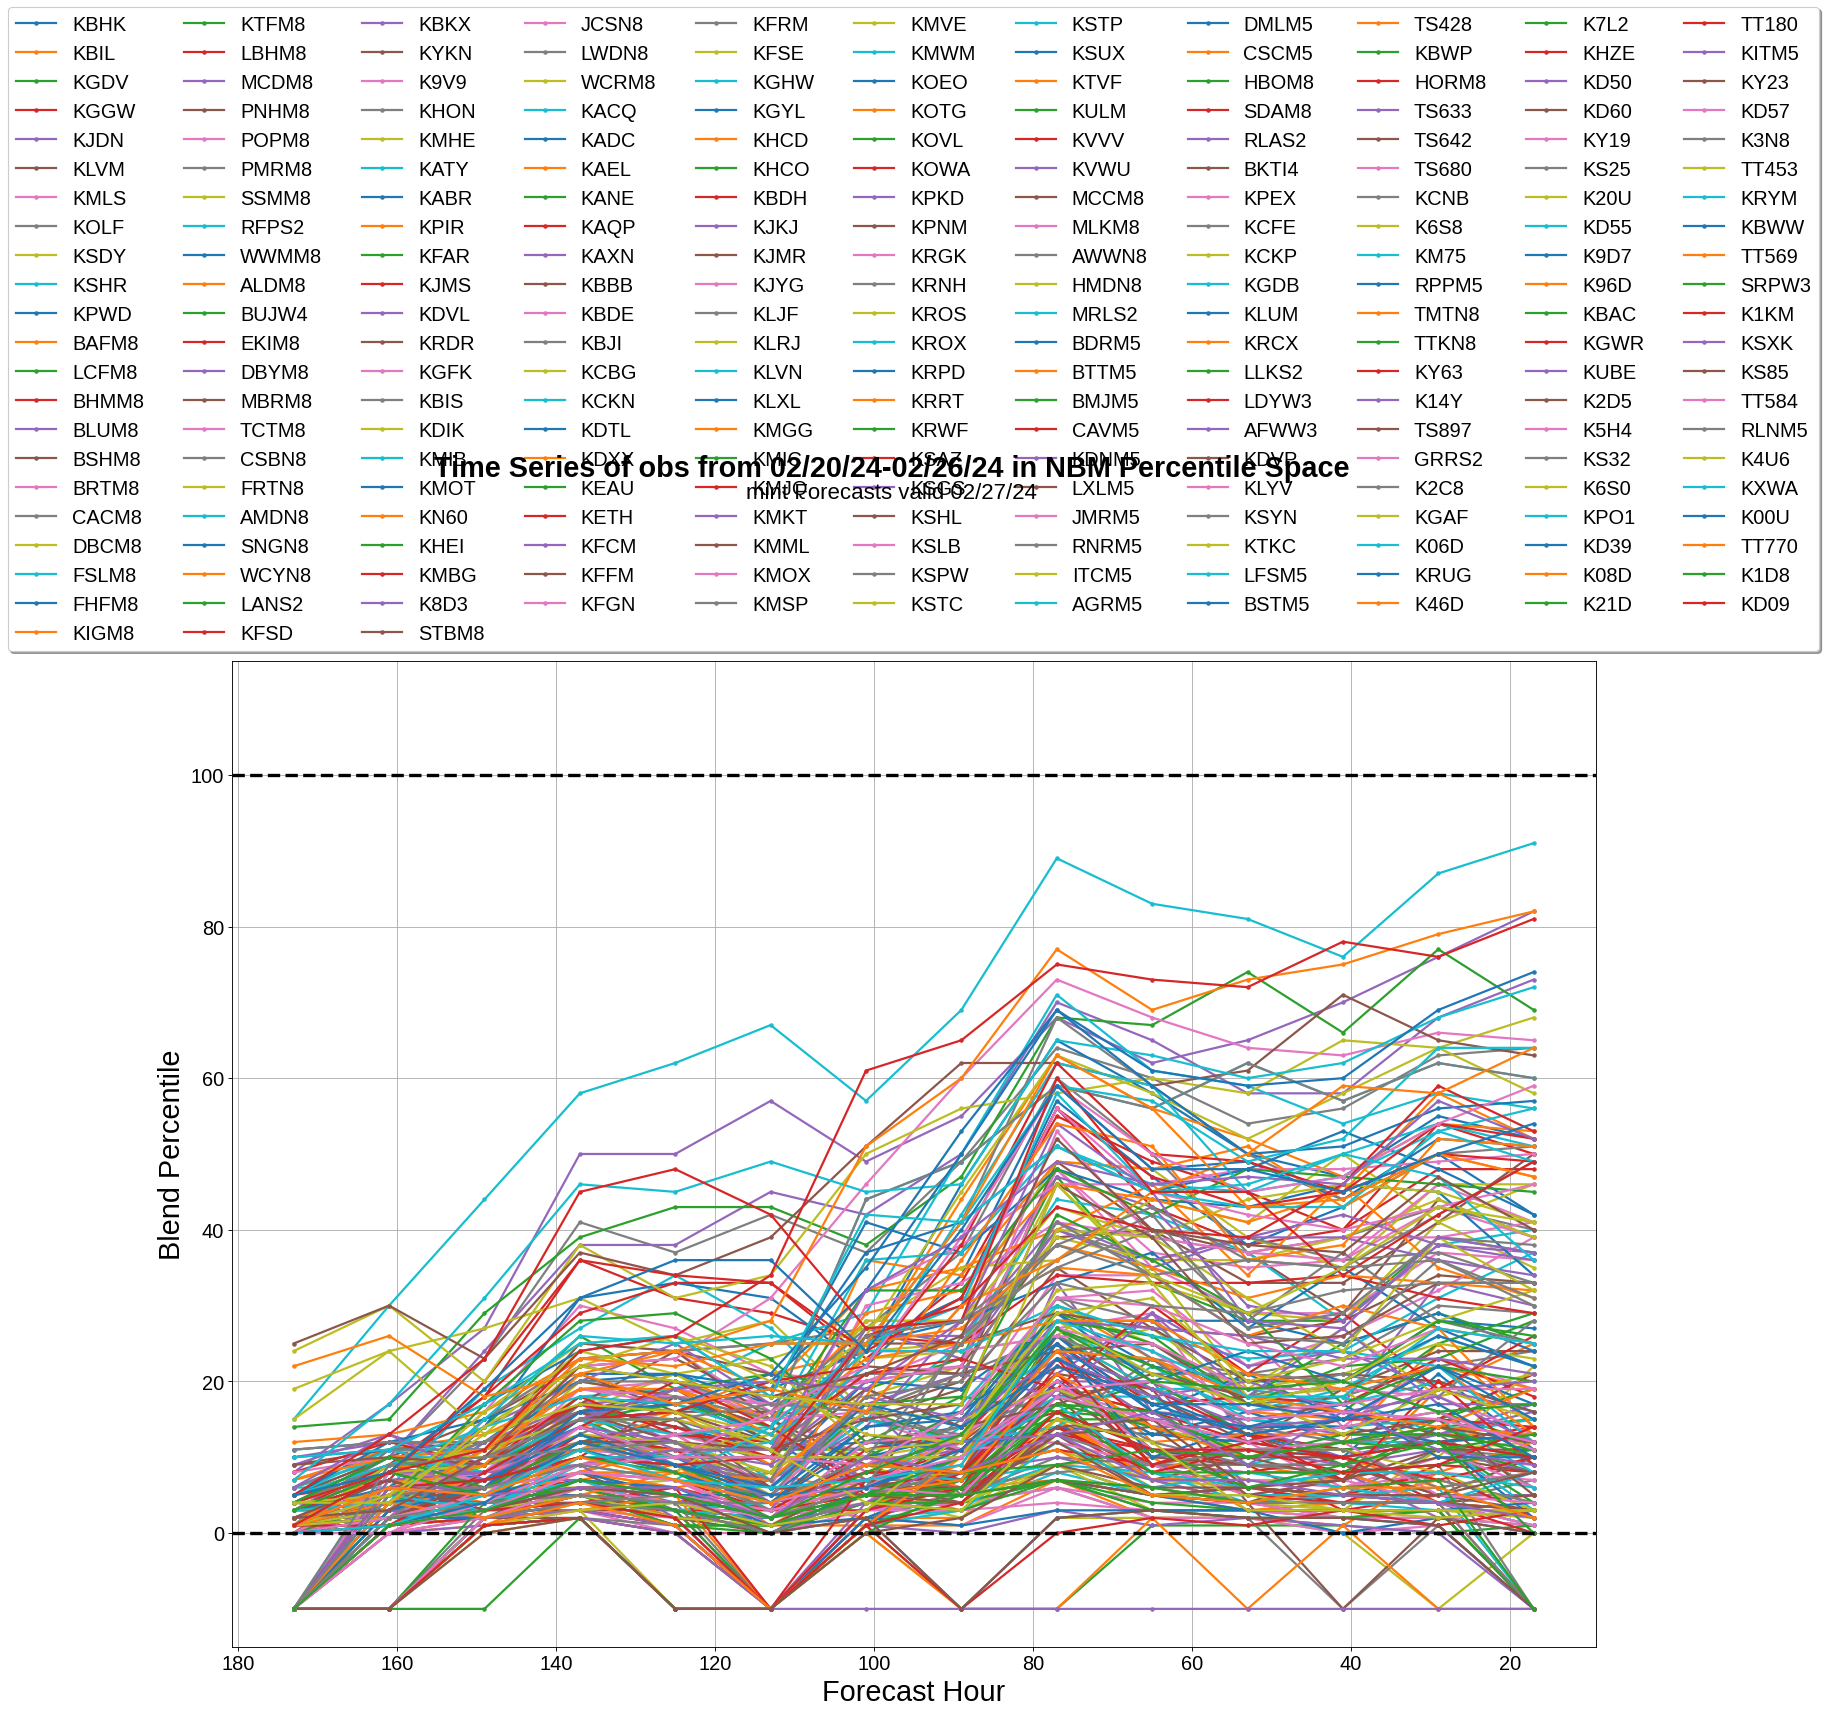

In [19]:
#@title Plotting Option Two - Obs in Percentile Space Over Time
#generate time series plot
matplotlib.rc('axes',facecolor='white',edgecolor='black')
figobs=plt.figure(constrained_layout=False,figsize=(22,16),dpi=80)
grid=figobs.add_gridspec(1,1)
axobs=figobs.add_subplot(1,1,1)
#combine obs and forecast dataframes into one
for region in region_list:
  allvals=pd.merge(masterfcst,obs[region],on='stid')
allvals.to_csv(region+'_'+element+'ob_percentiles_valid_'+valid_date_start.strftime('%m%d%y')+'.csv')
fcvals = pd.unique(allvals['forecast_hour'])
for stn in pd.unique(allvals['stid']):
  stnframe=allvals.loc[allvals['stid'] == stn]
  stnframe.plot(ax=axobs,x="forecast_hour",y="ob_perc",label=stn,xlabel="Forecast Hour",ylabel="Percentile",ylim=(-15,115),grid=True,marker='o',markersize=3,linewidth=2,fontsize=18)
axobs.legend(loc='lower center',bbox_to_anchor=[0.5,1.00],fancybox=True,shadow=True,ncol=11,prop={'size': 18})
axobs.set_xlim(axobs.get_xlim()[::-1])
title_string="Time Series of obs from " + fcst_start_date.strftime('%m/%d/%y')+ "-" + fcst_end_date.strftime('%m/%d/%y') + " in NBM Percentile Space"
sub_string=element + " Forecasts valid " + valid_date_start.strftime('%m/%d/%y')
#ax.set_title(title_string+'\n'+sub_string)
plt.axhline(0,color='black',linewidth=3,linestyle='dashed')
plt.axhline(100,color='black',linewidth=3,linestyle='dashed')
plt.xlabel("Forecast Hour",fontsize=26)
plt.ylabel("Blend Percentile",fontsize=26)
figobs.text(0.5,1.02,title_string,horizontalalignment='center',verticalalignment='bottom',weight='bold',fontsize=26)
figobs.text(0.5,1.02,sub_string,horizontalalignment='center',verticalalignment='top',fontsize=20)
figobs.savefig(region+'_'+element+'_ob_pctplot_bystn_valid_'+valid_date_start.strftime('%m%d%y')+".png") #,bbox_inches='tight')

In [ ]:
#@title Plotting Option Three - NBM-D in Percentile Space
#generate time series plot
matplotlib.rc('axes',facecolor='white',edgecolor='black')
if element == "maxwind":
  raise Exception("FATAL ERROR: No deterministic data available for maxwind")
figdet=plt.figure(constrained_layout=False,figsize=(22,16),dpi=80)
grid=figdet.add_gridspec(1,1)
axdet=figdet.add_subplot(1,1,1)
#combine obs and forecast dataframes into one
for region in region_list:
  allvals=pd.merge(masterfcst,obs[region],on='stid')
allvals.to_csv(region+'_'+element+'nbmd_percentiles_valid_'+valid_date_start.strftime('%m%d%y')+'.csv')
fcvals = pd.unique(allvals['forecast_hour'])
for stn in pd.unique(allvals['stid']):
  stnframe=allvals.loc[allvals['stid'] == stn]
  stnframe.plot(ax=axdet,x="forecast_hour",y="NBMd_perc",label=stn,xlabel="Forecast Hour",ylabel="Percentile",ylim=(-15,115),grid=True,marker='o',markersize=3,linewidth=2,fontsize=18)
axdet.legend(loc='lower center',bbox_to_anchor=[0.5,1.00],fancybox=True,shadow=True,ncol=11,prop={'size': 18})
axdet.set_xlim(axdet.get_xlim()[::-1])
title_string="Time Series of Deterministic NBM from " + fcst_start_date.strftime('%m/%d/%y')+ "-" + fcst_end_date.strftime('%m/%d/%y') + " in NBM Percentile Space"
sub_string=element + " Forecasts valid " + valid_date_start.strftime('%m/%d/%y')
#ax.set_title(title_string+'\n'+sub_string)
plt.axhline(0,color='black',linewidth=3,linestyle='dashed')
plt.axhline(100,color='black',linewidth=3,linestyle='dashed')
plt.xlabel("Forecast Hour",fontsize=26)
plt.ylabel("Blend Percentile",fontsize=26)
figdet.text(0.5,1.02,title_string,horizontalalignment='center',verticalalignment='bottom',weight='bold',fontsize=26)
figdet.text(0.5,1.02,sub_string,horizontalalignment='center',verticalalignment='top',fontsize=20)
figdet.savefig(region+'_'+element+'_nbmd_pctplot_bystn_valid_'+valid_date_start.strftime('%m%d%y')+".png") #,bbox_inches='tight')

In [ ]:
#@title Plotting Option Four - Individual Obs or Deterministic in Percentile Space
matplotlib.rc('axes',facecolor='white',edgecolor='black')
compare_to = "obs" #@param ["obs", "deterministic"]
cwa_outline = True #@param {type:"boolean"}
county_outline = True #@param {type:"boolean"}

if compare_to == "obs":
  compare_element = "Obs"
  compare_var = "ob_perc"
else:
  compare_element = "Detr"
  compare_var = "NBMd_perc"

title_dict = {"maxt":["Max T","PMaxT"],"mint":["Min T","PMinT"], "qpf":["QPF","PQPF"], "maxwind":["Max Wind","Prob Max Wind"], "snow":["Snow Acc", "Prob Snow Acc"]}
background_color = '#272727'
text_color = 'white'
map_land_color = '#414143'
map_water_color = '#272727'
map_border_color = 'white'
matplotlib.rc('axes',facecolor=background_color, edgecolor=text_color)

if element == "qpf":
  cmap = get_cmap('BrBG')
  cmap.set_under(color='black')
  cmap.set_over(color='yellow')
elif element == "snow":
  cmap = get_cmap('cool')
  cmap.set_under(color='black')
  cmap.set_over(color='yellow')
else:
  #cmap = 'Spectral'
  cmap = get_cmap('bwr')
  cmap.set_under(color='black')
  cmap.set_over(color='yellow')

if use_stageiv and element=="qpf":
  points_str = f'Stage IV @ {network_selection}'
else:
  points_str = network_selection

if (element == "qpf" or element == "snow"):
  valid_datetime = valid_date
  fig_valid_date = nbm_qmd_valid_end_datetime.strftime('%Y%m%d_%HZ')
  valid_title = nbm_qmd_valid_end_datetime.strftime('%HZ %a %m-%d-%Y')
else:
  valid_datetime = datetime.strptime(valid_date,'%Y-%m-%d')
  fig_valid_date = valid_datetime.strftime('%Y%m%d')
  valid_title = valid_datetime.strftime('%a %m-%d-%Y')

#if (element == "snow"):
#  nbm_init_title = core_init.strftime('%HZ %m-%d-%Y')
#else:
#  nbm_init_title = nbm_init.strftime('%HZ %m-%d-%Y')

def flip(items, ncol):
    return itertools.chain(*[items[i::ncol] for i in range(ncol)])

for fhr in pd.unique(masterfcst['forecast_hour']):

  tmpfcst=masterfcst.loc[masterfcst['forecast_hour'] == fhr]

  init_time=valid_datetime-timedelta(hours=fhr)
  nbm_init_title=init_time.strftime('%HZ %m-%d-%Y')

  if region_selection == "CONUS":
    dataframeid = "CONUS"
    #set up multipanel plot
    west =-125.650
    south = 23.377
    east = -66.008
    north = 50.924
    width_ratios = [7,3,3,3]
    lloc = "lower right"
    fig = plt.figure(constrained_layout=True, figsize=(16,9), facecolor=background_color, frameon=True, dpi=150)
    grid = fig.add_gridspec(4,4, width_ratios=width_ratios, hspace=0.2, wspace=0.2, left=0.1, right=0.9)
    fig.text(0.30, 0.885,f'{region_selection} {title_dict[element][0]} {compare_element} in NBM {title_dict[element][1]} Percentile Space',horizontalalignment='center',weight='bold',fontsize=25,color=text_color)
    fig.text(0.30, 0.855,f'Valid: {valid_title}  |  NBM Init: {nbm_init_title}  |  Points: {points_str}',horizontalalignment='center',fontsize=16,color=text_color)
    ax1 = fig.add_subplot(grid[:,:-2], projection=ccrs.Mercator(globe=None))
    ax2 = fig.add_subplot(grid[0,2])
    ax3 = fig.add_subplot(grid[0,3])
    ax4 = fig.add_subplot(grid[1,2])
    ax5 = fig.add_subplot(grid[1,3])
    ax6 = fig.add_subplot(grid[2:,2:])

    conus_df = pd.concat([pltfcst["WR"], pltfcst["CR"], pltfcst["ER"],pltfcst["SR"]])
    lats = conus_df["lat"].values
    lons = conus_df["lon"].values
    point_data = conus_df[compare_var].values
    mean = conus_df[compare_var].mean()
    median = conus_df[compare_var].median()
    mode = conus_df[compare_var].mode().values[0]

    proj = ccrs.PlateCarree()

    ax1.set_anchor('S')
    ax1.set_extent([west, east, south, north], crs=proj)
    #ax1.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-1)
    ax1.add_feature(cfeature.OCEAN, edgecolor='none', facecolor=map_water_color, zorder=-2)
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=map_land_color, zorder=-1))
    #ax1.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#272727', zorder=0)
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor=map_water_color, zorder=0))
    ax1.add_feature(cfeature.BORDERS, edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=1)
    #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'countries', '50m', edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2))
    ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border_color, facecolor='none', linewidth=1, zorder=2))
    #cx.add_basemap(ax1, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', attribution=False)
    scatter = ax1.scatter(lons, lats, c= point_data, cmap=cmap, s=45, transform=proj, vmin=0.0, vmax=100.0)
    #handles, labels = scatter.legend_elements(num=10)
    #legend1 = ax1.legend(flip(handles, 6), flip(labels, 6), ncol=6,loc=lloc, title=f'{compare_element} in NBM Percentile Space', fancybox=True)
    numcols=abs(np.amax(point_data) - np.amin(point_data))//10
    legend1 = ax1.legend(*scatter.legend_elements(num=numcols), loc=lloc, title=f'{compare_element} \n Rank', fancybox=True)
    plt.setp(legend1.get_title(), multialignment='center', color=text_color)
    for text in legend1.get_texts():
      text.set_color(text_color)
    ax1.add_artist(legend1)
    ax1.add_feature(cfeature.NaturalEarthFeature(
      'cultural', 'admin_1_states_provinces_lines', '110m',
      edgecolor='gray', facecolor='none'))
    if cwa_outline:
      try:
        if os.path.exists("shp/w_05mr24.zip"):
          pass
        else:
          cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_05mr24.zip"
          os.mkdir("shp")
          urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
          #!unzip shp/nws_cwa_outlines.zip -d shp
        with zipfile.ZipFile("shp/nws_cwa_outlines.zip", 'r') as zip_ref:
          zip_ref.extractall("shp")
          cwa_feature = ShapelyFeature(Reader("shp/w_05mr24.shp").geometries(),ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=0.5, linestyle=':', zorder=3)
        ax1.add_feature(cwa_feature)
      except:
        print("   > Aw shucks, no CWA boundaries for you. Sorry bout that.")
    if county_outline:
      try:
        if os.path.exists("shp/c_08mr23.zip"):
          pass
        else:
          county_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_05mr24.zip"
          os.mkdir("shp")
          urlretrieve(county_url, "shp/counties.zip")
        try:
          cty_feature
        except:
          with zipfile.ZipFile("shp/counties.zip",'r') as zip_ref:
            zip.ref.extractall("shp")
            cty_feature = ShapelyFeature(Reader("shp/c_05mr24.shp").geometries().ccrs.PlateCarree(), edgecolor='white',facecolor='none',linewidth=1.0,linestyle="--",zorder=3)
        ax1.add_feature(cty_feature)
      except:
        print("   > Cannot plot county boundaries.")

    mean_wr = tmpfcst["WR"][compare_var].mean()
    median_wr = tmpfcst["WR"][compare_var].median()
    #mode_wr = masterfcst["WR"][compare_var].mode().values[0]
    ax2.set_anchor('N')
    sns.histplot(data=tmpfcst["WR"], x=compare_var, ax=ax2, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
    ax2.set_xlabel("Western Region", color=text_color, fontsize=12)
    ax2.axvline(mean_wr, color='salmon', linestyle='--', label="Mean")
    ax2.axvline(median_wr, color='mediumaquamarine', linestyle='-', label="Median")
    #ax2.axvline(mode_wr, color='lightskyblue', linestyle='-', label="Mode")
    ax2.grid(False)
    for tick in ax2.get_xticklabels():
      tick.set_color(text_color)
    for tick in ax2.get_yticklabels():
      tick.set_color(text_color)
    ax2.tick_params(axis='y',labelsize=8, color=text_color)
    legend2 = ax2.legend()
    for text in legend2.get_texts():
      text.set_color(text_color)
    ax2.set(ylabel=None)

    mean_cr = tmpfcst["CR"][compare_var].mean()
    median_cr = tmpfcst["CR"][compare_var].median()
    #mode_cr = tmpfcst["CR"][compare_var].mode().values[0]
    ax3.set_anchor('N')
    sns.histplot(data=tmpfcst["CR"], x=compare_var, ax=ax3, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
    ax3.set_xlabel("Central Region", color=text_color, fontsize=12)
    ax3.axvline(mean_cr, color='salmon', linestyle='--', label="Mean")
    ax3.axvline(median_cr, color='mediumaquamarine', linestyle='-', label="Median")
    #ax3.axvline(mode_cr, color='lightskyblue', linestyle='-', label="Mode")
    ax3.grid(False)
    for tick in ax3.get_xticklabels():
      tick.set_color(text_color)
    for tick in ax3.get_yticklabels():
      tick.set_color(text_color)
    ax3.tick_params(axis='y',labelsize=8, color=text_color)
    legend3 = ax3.legend()
    for text in legend3.get_texts():
      text.set_color(text_color)
    ax3.set(ylabel=None)


    mean_er = tmpfcst["ER"][compare_var].mean()
    median_er = tmpfcst["ER"][compare_var].median()
    #mode_er = tmpfcst["ER"][compare_var].mode().values[0]
    ax4.set_anchor('N')
    sns.histplot(data=tmpfcst["ER"], x=compare_var, ax=ax4, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
    ax4.set_xlabel("Eastern Region", color=text_color, fontsize=12)
    ax4.axvline(mean_er, color='salmon', linestyle='--', label="Mean")
    ax4.axvline(median_er, color='mediumaquamarine', linestyle='-', label="Median")
    #ax4.axvline(mode_er, color='lightskyblue', linestyle='-', label="Mode")
    ax4.grid(False)
    for tick in ax4.get_xticklabels():
      tick.set_color(text_color)
    for tick in ax4.get_yticklabels():
      tick.set_color(text_color)
    ax4.tick_params(axis='y',labelsize=8, color=text_color)
    legend4 = ax4.legend()
    for text in legend4.get_texts():
      text.set_color(text_color)
    ax4.set(ylabel=None)


    mean_sr = tmpfcst["SR"][compare_var].mean()
    median_sr = tmpfcst["SR"][compare_var].median()
    #mode_sr = masterfcst["SR"][compare_var].mode().values[0]
    ax5.set_anchor('N')
    sns.histplot(data=tmpfcst["SR"], x=compare_var, ax=ax5, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
    ax5.set_xlabel("Southern Region", color=text_color, fontsize=12)
    ax5.axvline(mean_sr, color='salmon', linestyle='--', label="Mean")
    ax5.axvline(median_sr, color='mediumaquamarine', linestyle='-', label="Median")
    #ax5.axvline(mode_sr, color='lightskyblue', linestyle='-', label="Mode")
    ax5.grid(False)
    for tick in ax5.get_xticklabels():
      tick.set_color(text_color)
    for tick in ax5.get_yticklabels():
      tick.set_color(text_color)
    ax5.tick_params(axis='y',labelsize=8, color=text_color)
    legend5 = ax5.legend()
    for text in legend5.get_texts():
      text.set_color(text_color)
    ax5.set(ylabel=None)

    ax6.set_anchor('NC')
    sns.histplot(data=point_data, ax=ax6, kde=True, bins=range(0,110,10),color='steelblue',edgecolor='lightgrey')
    ax6.set_xlabel(f'{compare_element} in NBM {title_dict[element][1]} Percentile Bins', color=text_color, fontsize=12)
    ax6.axvline(mean, color='salmon', linestyle='--', label="Mean")
    ax6.axvline(median, color='mediumaquamarine', linestyle='-', label="Median")
    #ax6.axvline(mode, color='lightskyblue', linestyle='-', label="Mode")
    ax6.grid(False)
    for tick in ax6.get_xticklabels():
      tick.set_color(text_color)
    for tick in ax6.get_yticklabels():
      tick.set_color(text_color)
    ax6.tick_params(axis='y',labelsize=8, color=text_color)
    legend6 = ax6.legend()
    for text in legend6.get_texts():
      text.set_color(text_color)
    ax6.set(ylabel=None)

    #figname=region_selection+"_"+element+"_"+valid_date+".png"
    #plt.savefig(figname, facecolor=fig.get_facecolor(), bbox_inches=None, pad_inches=0.2, dpi='figure')

  else:
    #set up two panel plot
    if (region_selection == "WR"):
        west = -126.917
        south = 30.586
        east = -102.740
        north = 49.755
        width, height = (16,9)
        width_ratios = [9,8]
        lloc = "lower right"
    if (region_selection == "CR"):
        west = -111.534
        south = 33.295
        east = -81.723
        north = 49.755
        width, height = (16,7)
        width_ratios = [9,7]
        lloc = "lower center"
    if (region_selection == "ER"):
        west = -86.129
        south = 31.223
        east = -66.465
        north = 47.676
        width, height = (16,7.25)
        width_ratios = [6.9,9.5]
        lloc = "lower right"
    if (region_selection == "SR"):
        west = -109.758
        south = 23.313
        east = -79.247
        north = 36.899
        width, height = (16,5.6)
        width_ratios = [10,6]
        lloc = "lower center"
    if (region_selection == "CWA"):
        west = np.min(tmpfcst["lon"]) - 0.5
        south = np.min(tmpfcst["lat"]) - 0.5
        east = np.max(tmpfcst["lon"]) + 1.0
        north = np.max(tmpfcst["lat"]) + 0.5
        width, height = (16,9)
        ratioxy = 16./9.
        width_ratios = [ratioxy, 1]
        lloc = "center right"

    #width, height = (16,9)
    fig = plt.figure(constrained_layout=True, figsize=(width,height), facecolor=background_color, frameon=True, dpi=150)
    if (region_selection == "CWA"):
      dataframeid = cwa_id
    else:
      dataframeid = region_selection
    #ratioxy = 16./9.
    #width_ratios = [ratioxy, 1]
    grid = fig.add_gridspec(1,2, hspace=0.2, width_ratios=width_ratios, height_ratios = [1], wspace=0.2)
    ax1 = fig.add_subplot(grid[0,0], projection=ccrs.Mercator())
    #ax1 = fig.add_subplot(grid[0,0], projection=ccrs.LambertConformal(central_latitude=25, central_longitude=265, standard_parallels=(25,25)))
    ax2 = fig.add_subplot(grid[0,1], )
    fig.text(0.5, 1.05,f'{dataframeid} {title_dict[element][0]} {compare_element} in NBM v4.1 {title_dict[element][1]} Percentile Space',\
            horizontalalignment='center', verticalalignment='bottom', weight='bold',fontsize=20,color=text_color)
    fig.text(0.5, 1.05,f'Valid: {valid_title} | NBM Init: {nbm_init_title} | Points: {points_str}', \
            horizontalalignment='center',verticalalignment='top', fontsize=16,color=text_color)

    lats = tmpfcst["lat"].values
    lons = tmpfcst["lon"].values
    point_data = tmpfcst[compare_var].values
    mean = tmpfcst[compare_var].mean()
    median = tmpfcst[compare_var].median()
    #mode = tmpfcst.mode().values[0]
    proj = ccrs.PlateCarree()
    numcols=(abs(np.nanmax(point_data) - np.nanmin(point_data))//10) + 1

    ax1.set_anchor('N')
    ax1.set_facecolor(background_color)
    ax1.set_extent([west, east, south, north], crs=proj)
    #ax1.add_feature(cfeature.LAND, edgecolor='none', facecolor='#414143', zorder=-1)
    ax1.add_feature(cfeature.OCEAN, edgecolor='none', facecolor=map_water_color, zorder=-2)
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='none', facecolor=map_land_color, zorder=-1))
    #ax1.add_feature(cfeature.LAKES, edgecolor='none', facecolor='#272727', zorder=0)
    ax1.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', '10m', edgecolor='none', facecolor=map_water_color, zorder=0))
    ax1.add_feature(cfeature.BORDERS, edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2)
    #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'countries', '50m', edgecolor=map_border_color, facecolor='none', linewidth=2, zorder=2))
    ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border_color, facecolor='none', linewidth=1, zorder=5))
    #ax1.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_1_states_provinces_lines', '50m', edgecolor=map_border, facecolor='none', linewidth=1, zorder=5))
    #cx.add_basemap(ax1, source='https://server.arcgisonline.com/ArcGIS/rest/services/Canvas/World_Dark_Gray_Base/MapServer/tile/{z}/{y}/{x}', attribution=False)
    scatter = ax1.scatter(lons, lats, c= point_data, cmap=cmap, s=45, transform=proj, zorder=2, vmin=0.0, vmax=100.0)

    if region_selection in ("CR","SR"):
      handles, labels = scatter.legend_elements(num=numcols)
      legend1 = ax1.legend(flip(handles, 6), flip(labels, 6), ncol=6,loc=lloc, title=f'{compare_element} in NBM Percentile Space', fancybox=True)
    else:
      legend1 = ax1.legend(*scatter.legend_elements(num=numcols),
                        loc=lloc, title=f'{compare_element} \n Rank', fancybox=True)
    plt.setp(legend1.get_title(), multialignment='center', color=text_color)
    for text in legend1.get_texts():
      text.set_color(text_color)
    ax1.add_artist(legend1)
    #ax1.set(aspect='equal', adjustable='box')
    if cwa_outline:
      try:
        if os.path.exists("shp/w_08mr23.shp"):
          pass
        else:
          cwa_url = "https://www.weather.gov/source/gis/Shapefiles/WSOM/w_08mr23.zip"
          if os.path.exists("shp"):
            pass
          else:
            os.mkdir("shp")
          urlretrieve(cwa_url, "shp/nws_cwa_outlines.zip")
          #!unzip shp/nws_cwa_outlines.zip -d shp
        with zipfile.ZipFile("shp/nws_cwa_outlines.zip", 'r') as zip_ref:
          zip_ref.extractall("shp")
          cwa_feature = ShapelyFeature(Reader("shp/w_08mr23.shp").geometries(),ccrs.PlateCarree(), edgecolor='black', facecolor='none', linewidth=1, linestyle='-', zorder=4)
          ax1.add_feature(cwa_feature)
      except:
        print("Aw shucks, no CWA boundaries for you. Sorry bout that.")
    if county_outline:
      try:
        if os.path.exists("shp/counties.zip"):
          pass
        else:
          county_url = "https://www.weather.gov/source/gis/Shapefiles/County/c_08mr23.zip"
          if os.path.exists("shp"):
            pass
          else:
            os.mkdir("shp")
          urlretrieve(county_url, "shp/counties.zip")
          print("   >> Downloaded county zip file")
        try:
          cty_feature
        except:
          with zipfile.ZipFile("shp/counties.zip",'r') as cty_ref:
            cty_ref.extractall("shp")
            print("   >> Extracted county shape files")
            cty_feature = ShapelyFeature(Reader("shp/c_08mr23.shp").geometries(),ccrs.PlateCarree(), edgecolor='grey', facecolor='none', linewidth=0.5, linestyle=':', zorder=3)
        ax1.add_feature(cty_feature)
      except:
        print("   >> Cannot plot county boundaries.")

    #if region_selection == "SR":
    #ax2.set(aspect=1)
    ax2.set_anchor('C')
    sns.histplot(data=tmpfcst, x=compare_var, ax=ax2, kde=True, bins=range(-10,115,10),color='steelblue',edgecolor='lightgrey')
    ax2.set_xlabel(f'{compare_element} in NBM {title_dict[element][1]} Percentile Bins', color=text_color, fontsize=12)
    ax2.axvline(mean, color='salmon', linestyle='--', label="Mean")
    ax2.axvline(median, color='mediumaquamarine', linestyle='-', label="Median")

    ax2.grid(False)
    for tick in ax2.get_xticklabels():
      tick.set_color(text_color)
    for tick in ax2.get_yticklabels():
      tick.set_color(text_color)
    ax2.tick_params(axis='y',labelsize=8, color=text_color)
    legend2 = ax2.legend()
    for text in legend2.get_texts():
      text.set_color(text_color)
    ax2.set(ylabel=None)


  figname=dataframeid+"_"+compare_element+"_"+element+"_"+valid_end_datetime.strftime('%Y%m%d')+"_fh"+str(int(fhr))+".png"
  plt.savefig(figname, facecolor=fig.get_facecolor(), bbox_inches='tight', pad_inches=0.2, dpi='figure')
  print(f'   > Done! Saved plot as {figname}')

Text(0.5, 0.95, 'valid at 02/27/24 over WFO BIS,GGW,BYZ,ABR,UNK,FGF,FSD,MPX')

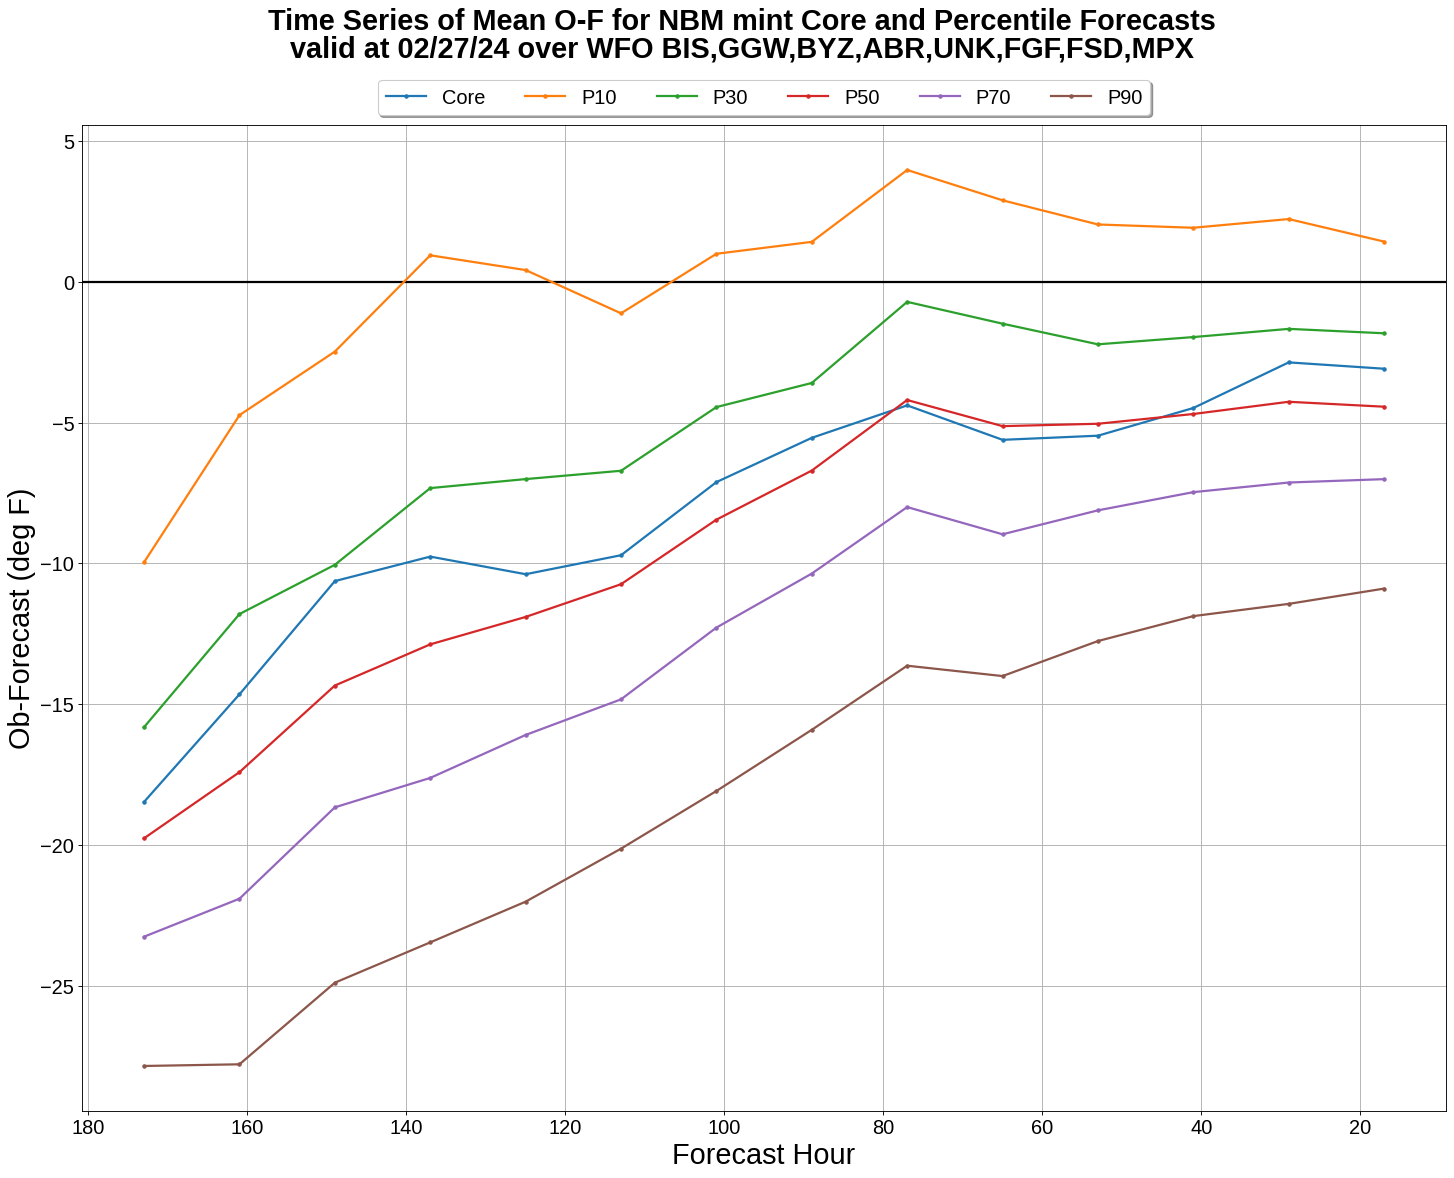

In [35]:
#@title Plotting Option Five - O/Fs for percentiles and core
matplotlib.rc('axes',facecolor='white',edgecolor='black')
masterfcst['Core']=masterfcst['OB']-masterfcst['NBM_D']
masterfcst['P10']=masterfcst['OB']-masterfcst['NBM_P10']
masterfcst['P30']=masterfcst['OB']-masterfcst['NBM_P30']
masterfcst['P50']=masterfcst['OB']-masterfcst['NBM_P50']
masterfcst['P70']=masterfcst['OB']-masterfcst['NBM_P70']
masterfcst['P90']=masterfcst['OB']-masterfcst['NBM_P90']
units={"maxt":"deg F", "mint":"deg F", "qpf":"in", "maxwind":"kts", "snow":"in"}
figdiff=plt.figure(constrained_layout=False,figsize=(22,16),dpi=80)
grid=figdiff.add_gridspec(1,1)
axdiff=figdiff.add_subplot(1,1,1)
difframe=masterfcst.groupby(['forecast_hour'])[['forecast_hour','Core','P10','P30','P50','P70','P90']].mean()
plt.axhline(0,color='black',linewidth=2,linestyle='solid')
for var in ['Core','P10','P30','P50','P70','P90']:
  difframe.plot(ax=axdiff,kind="line",x="forecast_hour",y=var,grid=True,marker='o',markersize=3,fontsize=18,linewidth=2)
axdiff.legend(loc='lower center',bbox_to_anchor=[0.5,1.00],fancybox=True,shadow=True,ncol=6,prop={'size': 18})
axdiff.set_xlim(axdiff.get_xlim()[::-1])
plt.xlabel("Forecast Hour",fontsize=26)
plt.ylabel("Ob-Forecast (" + units[element] + ")",fontsize=26)
title_string="Time Series of Mean O-F for NBM " + element + " Core and Percentile Forecasts"
subtitle_string= "valid at " + valid_date_start.strftime('%m/%d/%y')  + " over WFO " + region
figdiff.text(0.5,0.95,title_string,horizontalalignment='center',verticalalignment='bottom',weight='bold',fontsize=26)
figdiff.text(0.5,0.95,subtitle_string,horizontalalignment='center',verticalalignment='top',weight='bold',fontsize=26)